In [1]:
import sys
sys.path.append("..")

from models.taylorf2 import taylorf2
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np
config.update("jax_enable_x64", True)
import corner

# Instantiate model class

In [2]:
injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# Define prior ranges
priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([27.5, 32.5])
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

# Instantiate model
model = taylorf2(injection, priorDict)

SNR is: 18.549376129849225


# What does the strain look like?

Text(0.5, 1.0, 'Gravitational wave strain data')

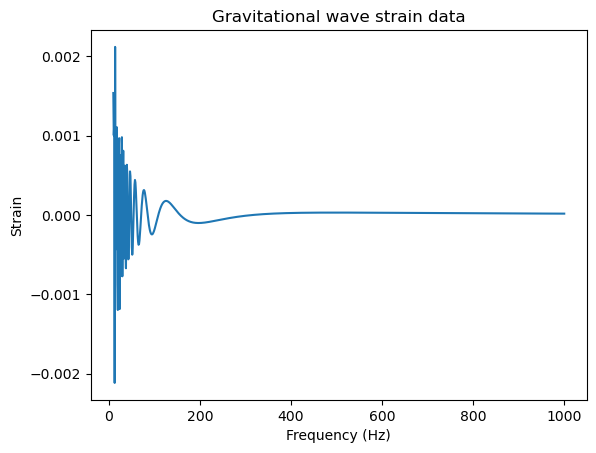

In [9]:
plt.plot(model.frequency, model.strain(injection, model.frequency))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('Gravitational wave strain data')

# Run some quick checks on the derivatives

In [10]:
x = model.injection + np.random.uniform(low=0, high=0.0001, size=5)

print('Make sure autodiff and analytically calculated gradient of strain agree')
print(jax.jacfwd(model.strain)(x,10))
print(model.gradient_strain(x, 10))

# -------------------------------------------------------------------------------

print('Make sure derivative of potentials agree')
print(jax.jacfwd(model.potential_single)(x))
print(model.gradient_potential_single(x))

# -------------------------------------------------------------------------------

print('Make sure Jacobian calculation is stable')
print(jax.jacrev(model.potential_single)(x))
print(jax.jacfwd(model.potential_single)(x))

Make sure autodiff and analytically calculated gradient of strain agree
[ 0.19109014-0.09661315j -0.00304129+0.00153765j -0.03643416+0.01842072j
 -0.12287743+0.06212553j  0.03073987+0.06080007j]
[ 0.19109014-0.09661315j -0.00304129+0.00153765j -0.03643416+0.01842072j
 -0.12287743+0.06212553j  0.03073987+0.06080007j]
Make sure derivative of potentials agree
[ 1.50279310e+04 -9.32731267e+00 -3.44238183e+00 -3.02603334e+01
  8.26528971e+00]
[ 1.50279310e+04 -9.32731267e+00 -3.44238183e+00 -3.02603334e+01
  8.26528971e+00]
Make sure Jacobian calculation is stable
[ 1.50279310e+04 -9.32731267e+00 -3.44238183e+00 -3.02603334e+01
  8.26528971e+00]
[ 1.50279310e+04 -9.32731267e+00 -3.44238183e+00 -3.02603334e+01
  8.26528971e+00]


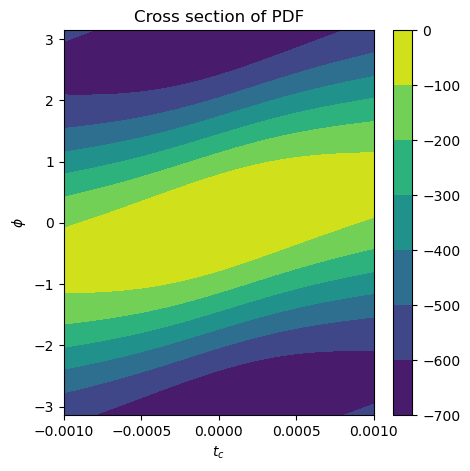

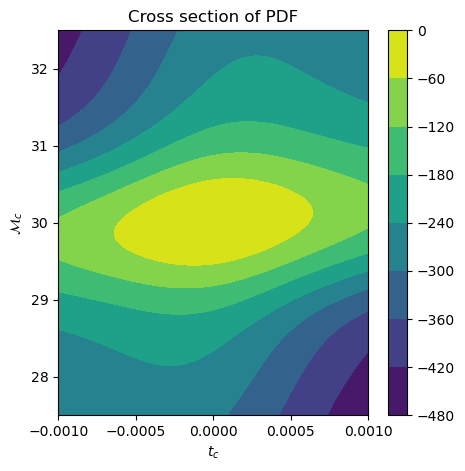

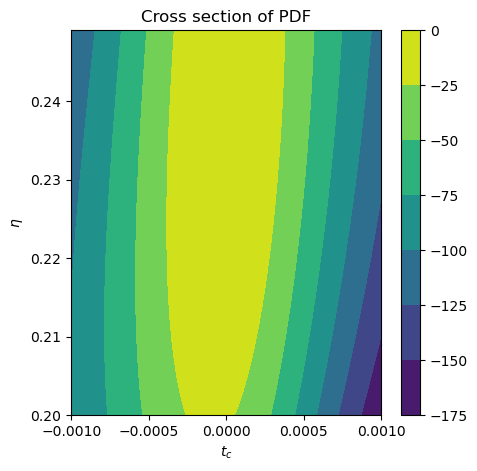

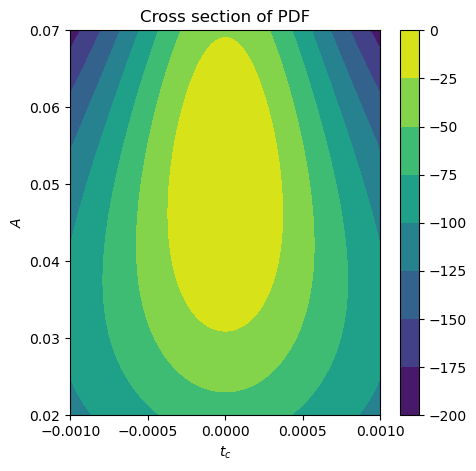

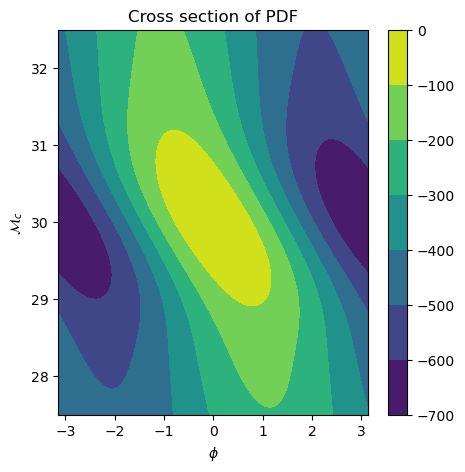

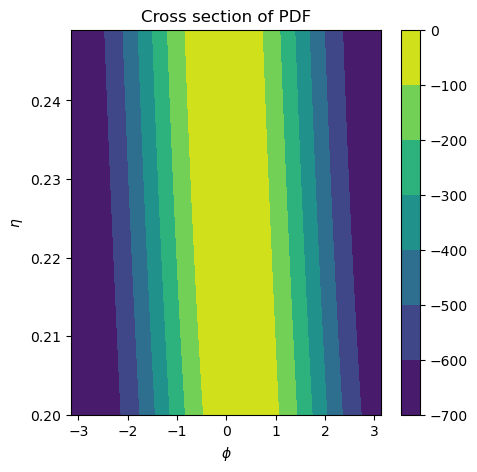

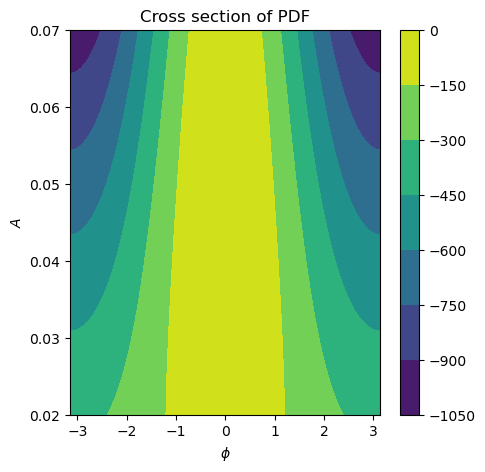

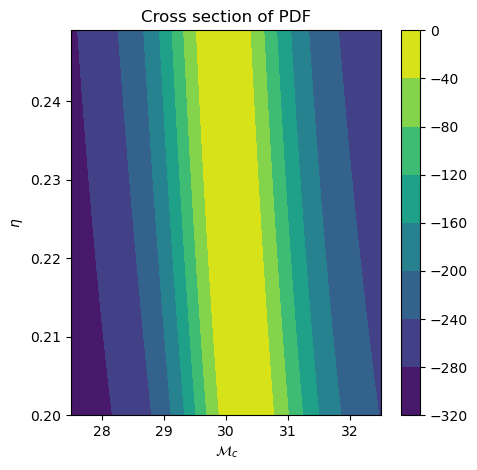

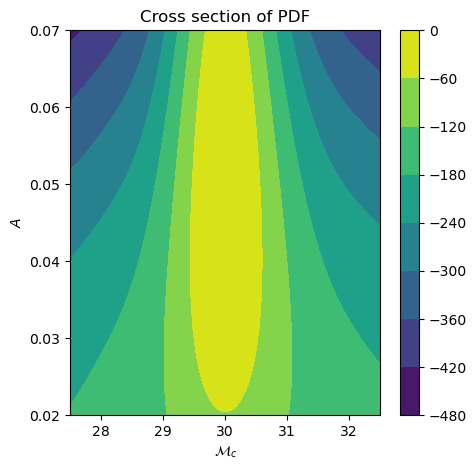

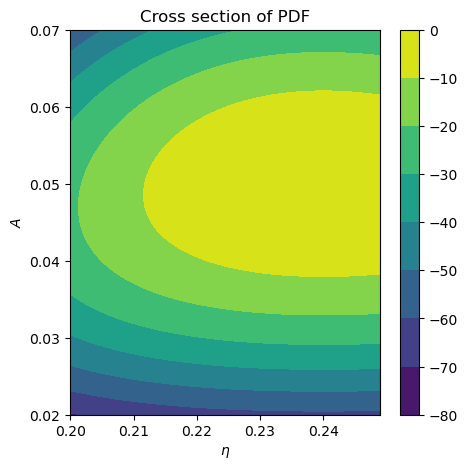

In [6]:
# Calculate cross sections of PDF

def getCrossSection(index1, index2, func, injection, lower_bound, upper_bound, index_label, ngrid=200):
    DoF = len(injection)
    x = np.linspace(lower_bound[index1], upper_bound[index1], ngrid)
    y = np.linspace(lower_bound[index2], upper_bound[index2], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T

    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]

    Z = func(particle_grid).reshape(ngrid,ngrid)

    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index_label[index1])
    ax.set_ylabel(index_label[index2])
    ax.set_title('Cross section of PDF')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        getCrossSection(i, j, neg_potential, injection, model.lower_bound, model.upper_bound, model.index_label)